The code from plot_generation.ipynb will be the foundation for most of this.

The main change I wanted to make was that the information for the Manhattan plot should be source from the GWAS sumstats file, and not the assoc.dat file.
In addition, we are interested in looking at all the chromosomes at one time for the Manahattan plot.
Since we already have that data we can make that change now.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def manhattan(pop, p_threshold=5e-8, subsample_rate=0.01):
    # Read the GWAS summary statistics file
    file_path = f'../data/raw/gwas/HF_Bothsex_{pop}_inv_var_meta_GBMI_052021_nbbkgt1.txt.gz'
    df = pd.read_csv(file_path, compression='gzip', sep='\t', header=0)

    # Ensure required columns exist
    required_cols = {'#CHR', 'POS', 'inv_var_meta_p'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing required columns in input file: {required_cols - set(df.columns)}")

    # Rename columns for consistency
    df = df.rename(columns={'#CHR': 'CHR', 'inv_var_meta_p': 'P'})

    # Select relevant columns and drop missing values
    df = df[['CHR', 'POS', 'P']].dropna()
    
    # Convert P-values to -log10(P) for plotting
    df['P'] = pd.to_numeric(df['P'], errors='coerce')
    df = df.dropna()  # Drop any remaining NaNs
    df['-log10(P)'] = df['P'].apply(lambda x: -np.log10(x))

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Apply filtering:
    df_significant = df[df['P'] <= p_threshold]  # Keep all SNPs below threshold
    df_nonsignificant = df[df['P'] > p_threshold].sample(frac=subsample_rate, random_state=42)  # Subsample 1% of non-significant SNPs

    # Combine both datasets
    df = pd.concat([df_significant, df_nonsignificant])

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR', 'POS'])

    # Generate a Manhattan plot
    plt.figure(figsize=(20, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Create chromosome index mapping
    df['Chrom_Position'] = df.groupby('CHR')['POS'].transform(lambda x: x - x.min())

    # Set up x-axis positions
    chrom_max = df.groupby('CHR')['Chrom_Position'].max()
    chrom_offsets = chrom_max.cumsum().shift(fill_value=0)
    df['Adjusted_POS'] = df['Chrom_Position'] + df['CHR'].map(chrom_offsets)

    # Plot each chromosome separately
    for i, chrom in enumerate(df['CHR'].unique()):
        chr_data = df[df['CHR'] == chrom]
        plt.scatter(chr_data['Adjusted_POS'], chr_data['-log10(P)'], 
                    color=colors[i % 2], s=5)

    # Add significance threshold line
    #plt.axhline(y=-np.log10(p_threshold), color='black', linestyle='dashed', linewidth=1)

    # Format x-axis to show chromosome numbers
    tick_positions = chrom_offsets + chrom_max / 2
    plt.xticks(tick_positions, [str(chrom) for chrom in chrom_offsets.index])

    # Labels and title
    plt.xlabel("Chromosome")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Manhattan Plot of GWAS Data (Population: {pop})")

    plt.show()

    plt.savefig(f'../plots/manhattan/{pop}_manhattan.png')

In [5]:
manhattan('afr',  p_threshold=5e-1)

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/gwas/HF_Bothsex_afr_inv_var_meta_GBMI_052021_nbbkgt1.txt.gz'

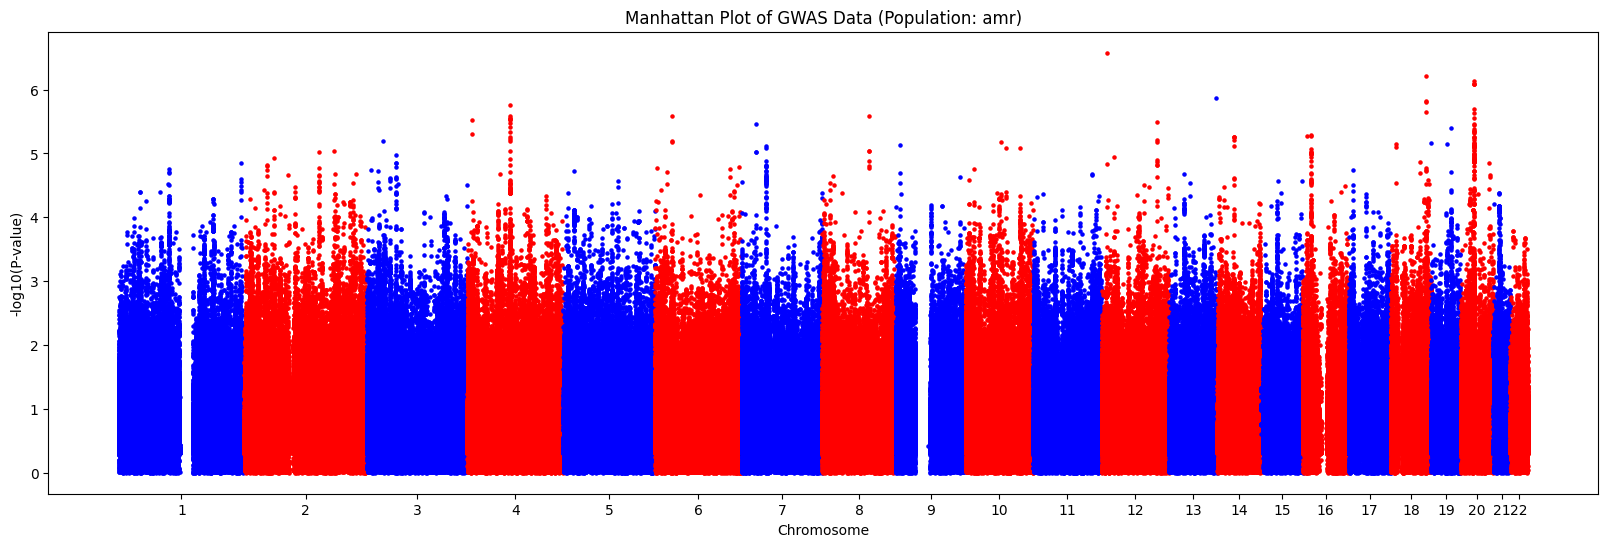

<Figure size 640x480 with 0 Axes>

In [8]:
manhattan('amr',  p_threshold=5e-1)

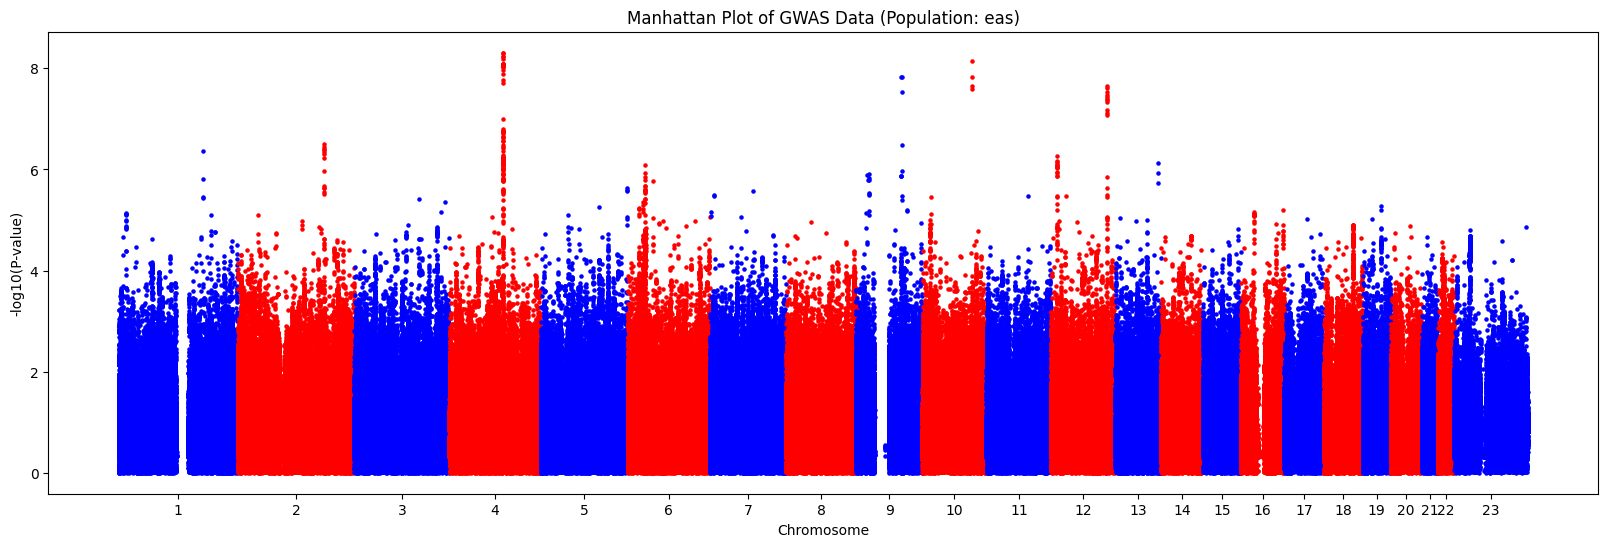

<Figure size 640x480 with 0 Axes>

In [9]:
manhattan('eas',  p_threshold=5e-1)

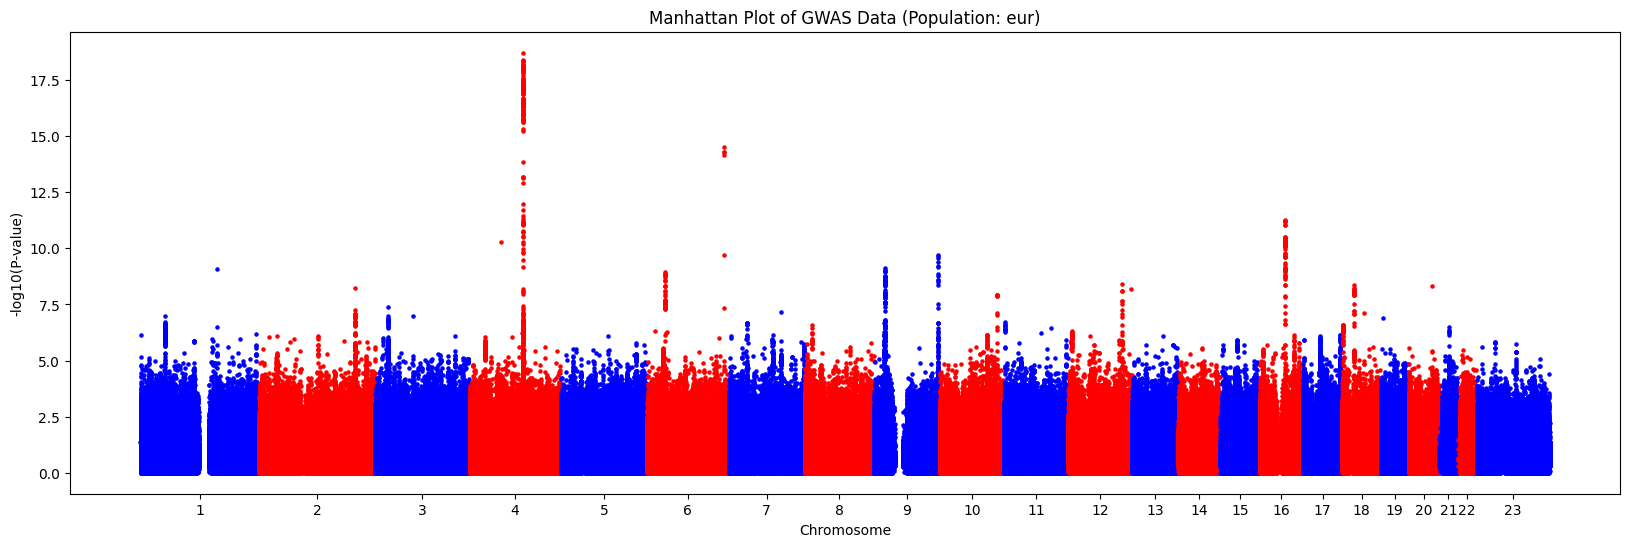

<Figure size 640x480 with 0 Axes>

In [10]:
manhattan('eur',  p_threshold=5e-1)

In [13]:
def data_prep(pop):
    """Reads GWAS summary statistics for all chromosomes and concatenates them."""
    all_dfs = []

    for chrom_num in range(1, 23):  # Loop through chromosomes 1-22
        file_path = f'../data/gene_associations/chr{chrom_num}.{pop}.assoc.dat'
        
        try:
            df = pd.read_csv(file_path, sep="\t")

            df = df.drop(columns=['PANEL', 'FILE'])
            df = df.set_index('ID')

            # Select relevant columns
            df = df[['CHR', 'P0', 'TWAS.P']].dropna()

            # Strip whitespace and convert to numeric, forcing errors to NaN
            df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

            # Drop NaN values
            df = df.dropna()

            # Convert P-values to -log10(P) for plotting
            df['TWAS.P'] = df['TWAS.P'].astype(float)
            df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

            # Convert chromosome numbers to integers for sorting
            df['CHR'] = df['CHR'].astype(int)

            # Sort by chromosome and position
            df = df.sort_values(by=['CHR', 'P0'])

            all_dfs.append(df)  # Store processed df

        except FileNotFoundError:
            print(f"File not found: {file_path}, skipping chromosome {chrom_num}")

    # Concatenate all chromosome data
    final_df = pd.concat(all_dfs, ignore_index=True)

    return final_df


In [15]:
data_prep('afr')

,CHR,P0,TWAS.P,-log10(P)
0,1,1661477,0.70535,0.151595
1,1,1724837,0.66616,0.176421
2,1,2555638,0.78687,0.104097
3,1,6236239,0.81942,0.086493
4,1,7846691,0.30728,0.512466
...,...,...,...,...
1470,22,50200978,0.46020,0.337053
1471,22,50255196,0.95380,0.020543
1472,22,50551111,0.51000,0.292430
1473,22,50583025,0.23060,0.637141


In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def miami(pop):
    """Generates a Miami plot for chromosomes 1-22 comparing given population vs 'eur'."""
    
    # Get GWAS data for both populations across all chromosomes
    df1 = data_prep(pop)  # Target population (e.g., Genotyped)
    df2 = data_prep('eur')  # European reference population (e.g., Imputed)

    # Set up the plot
    plt.figure(figsize=(14, 6))
    colors1 = ['darkgreen', 'lightgreen']  # Colors for one dataset (Imputed)
    colors2 = ['darkblue', 'lightblue']  # Colors for the other dataset (Genotyped)

    # Track chromosome positions for spacing
    chrom_offsets = {}
    cumulative_pos = 0

    for chrom in range(1, 23):
        chr_data1 = df1[df1['CHR'] == chrom]
        chr_data2 = df2[df2['CHR'] == chrom]

        if not chr_data1.empty and not chr_data2.empty:
            min_pos = min(chr_data1['P0'].min(), chr_data2['P0'].min())
            max_pos = max(chr_data1['P0'].max(), chr_data2['P0'].max())

            chr_data1 = chr_data1.copy()  # Ensure it’s a new DataFrame
            chr_data2 = chr_data2.copy()  # Ensure it’s a new DataFrame

            chr_data1.loc[:, 'plot_pos'] = chr_data1['P0'] - min_pos + cumulative_pos
            chr_data2.loc[:, 'plot_pos'] = chr_data2['P0'] - min_pos + cumulative_pos


            # Store chromosome midpoint for labeling
            chrom_offsets[chrom] = cumulative_pos + (max_pos - min_pos) / 2
            cumulative_pos += max_pos - min_pos + 1e6  # Add buffer between chromosomes

            # Plot Imputed data (positive direction)
            plt.scatter(chr_data1['plot_pos'], chr_data1['-log10(P)'],
                        color=colors1[chrom % 2], s=5, alpha=0.6, label="eur" if chrom == 1 else "")

            # Plot Genotyped data (negative direction)
            plt.scatter(chr_data2['plot_pos'], -chr_data2['-log10(P)'],
                        color=colors2[chrom % 2], s=5, alpha=0.6, label=f"{pop}" if chrom == 1 else "")

    # Remove chromosome number blocks (previously a solid bar)
    # Just use simple xticks for chromosome positions
    plt.xticks([])  # Removes chromosome numbers from x-axis

    # Adjust y-axis: Make both sides positive
    max_y = max(df1['-log10(P)'].max(), df2['-log10(P)'].max()) + 2
    y_ticks = np.arange(0, np.ceil(max_y), 2)
    plt.yticks(list(y_ticks) + list(-y_ticks))  # Mirror y-axis labels
    plt.ylim(-max_y, max_y)  # Set limits for symmetry

    

    # Add genome-wide significance threshold lines
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='solid', linewidth=1)
    plt.axhline(y=np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("Genomic Position")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data (Population: {pop} vs eur, Chromosomes 1-22)")
    plt.legend(loc="upper right", markerscale=3, fontsize=8)

    # Show the plot
    plt.show()

    # Optionally save the plot
    # os.makedirs(f'../plots/miami/{pop}', exist_ok=True)
    # plt.savefig(f'../plots/miami/{pop}/chr1-22.png', dpi=300)


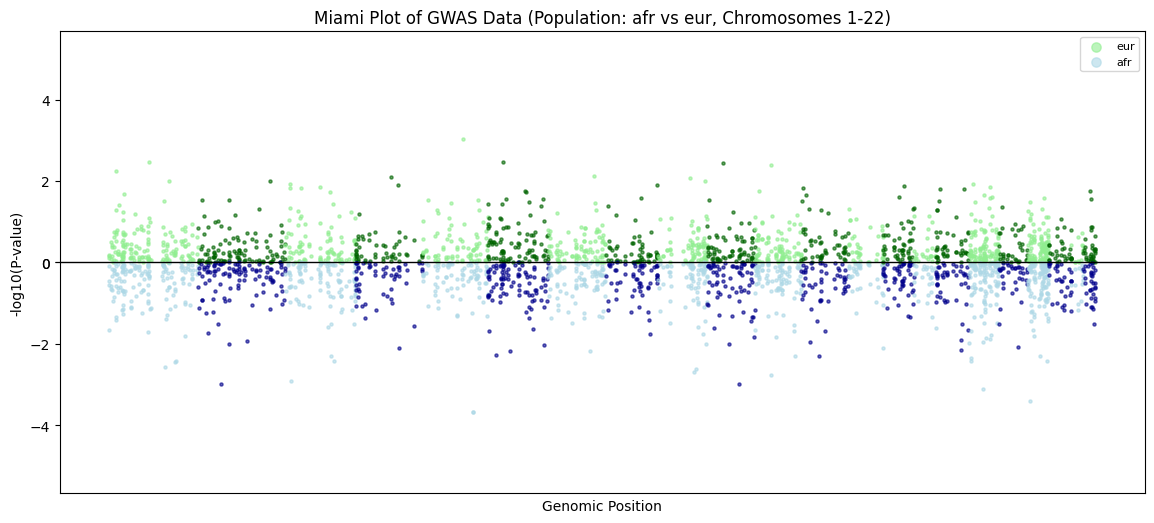

In [36]:
miami('afr')

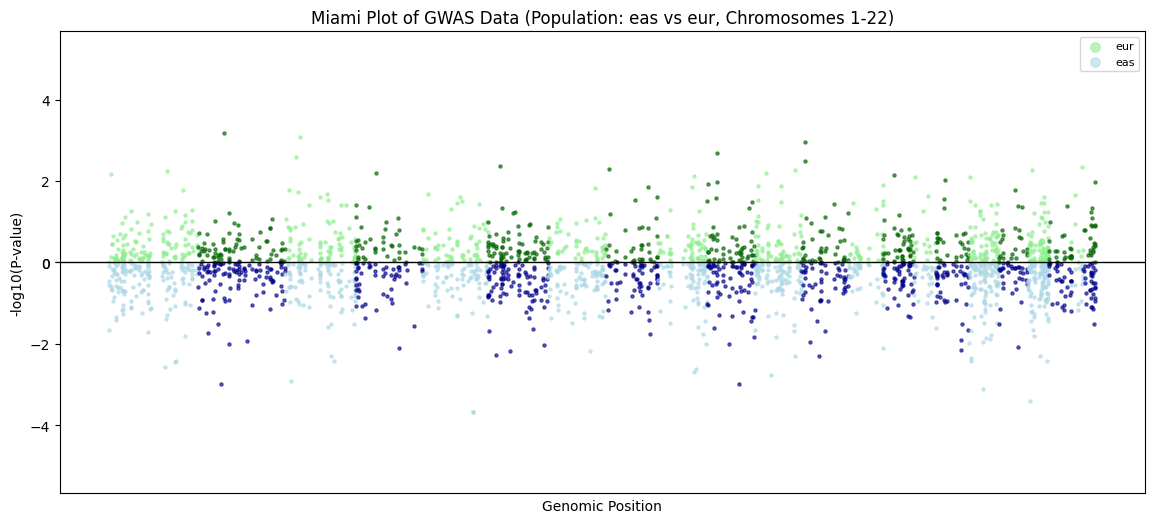

In [37]:
miami('eas')

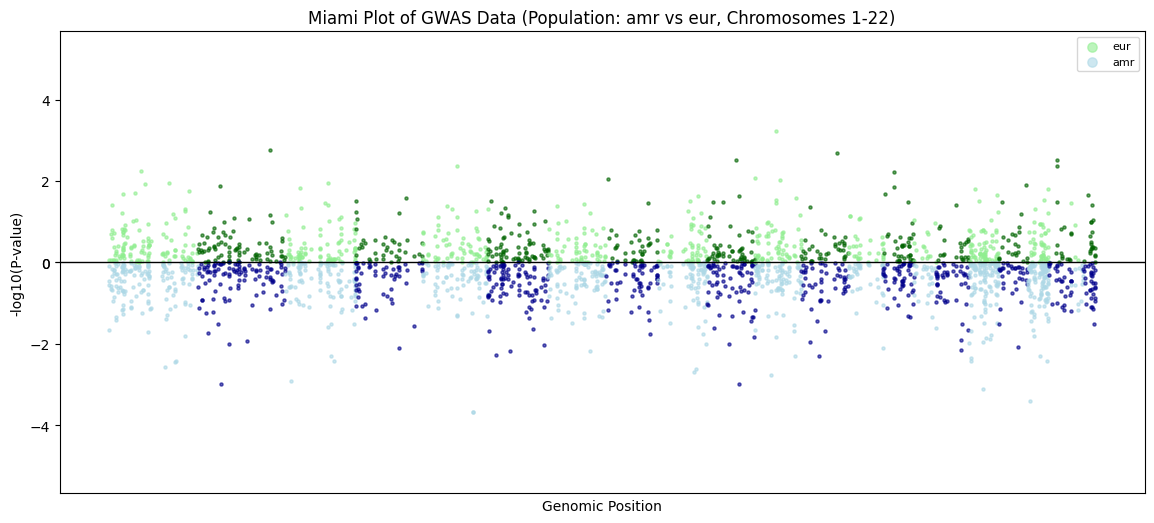

In [38]:
miami('amr')

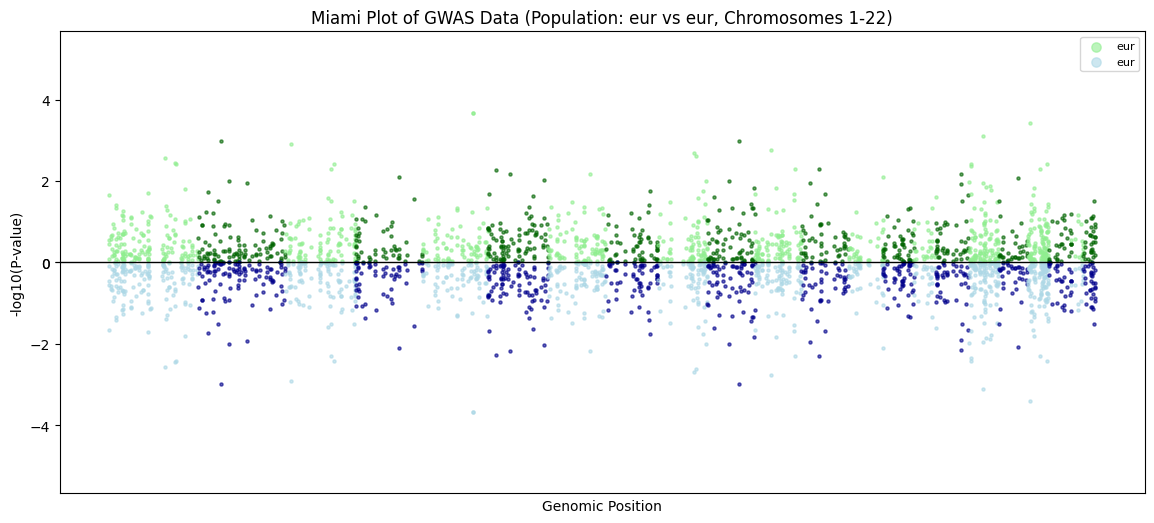

In [39]:
miami('eur')

In [ ]:
def data_prep(chrom_num, pop):
    # Read the GWAS summary statistics file

    file_path = f'../data/assoc/{chrom_num}.{pop}.assoc.dat'

    df = pd.read_csv(file_path, sep="\t")

    df = df.drop(columns=['PANEL', 'FILE'])

    df = df.set_index('ID')

    # Select relevant columns
    df = df[['CHR', 'P0', 'TWAS.P']].dropna()  # Drop missing values

    # Strip whitespace and convert to numeric, forcing errors to NaN
    df['TWAS.P'] = pd.to_numeric(df['TWAS.P'].str.strip(), errors='coerce')

    # Drop NaN values
    df = df.dropna()

    # Convert P-values to -log10(P) for plotting
    # df['-log10(P)'] = -np.log10(df['TWAS.P'])
    df['TWAS.P'] = df['TWAS.P'].astype(float)
    df['-log10(P)'] = df['TWAS.P'].apply(lambda x: -np.log10(x))    

    # Convert chromosome numbers to integers for sorting
    df['CHR'] = df['CHR'].astype(int)

    # Sort by chromosome and position
    df = df.sort_values(by=['CHR'])

    return df

In [ ]:
def miami(chrom_num, pop):

    df1 = data_prep(chrom_num, pop)
    df2 = data_prep(chrom_num, 'eur')

    print(f"Data for {pop}:")
    print(df1.describe())
    print(f"Data for eur:")
    print(df2.describe())

    # Set up the plot
    plt.figure(figsize=(12, 6))
    colors = ['blue', 'red']  # Alternating colors for chromosomes

    # Plot each chromosome separately
    for i, chrom in enumerate(df1['CHR'].unique()):
        chr_data = df1[df1['CHR'] == chrom]
        plt.scatter(chr_data['P0'], chr_data['-log10(P)'], 
                    color=colors[i % 2], label=f'{pop}', s=5)
        
    # Plot each chromosome separately
    for i, chrom in enumerate(df2['CHR'].unique()):
        chr_data = df2[df2['CHR'] == chrom]
        plt.scatter(chr_data['P0'], -chr_data['-log10(P)'], 
                    color=colors[1], label=f'eur', s=5)

    # Add significance threshold line (suggested genome-wide threshold: 5e-8)
    plt.axhline(y=-np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    plt.axhline(y=np.log10(5e-8), color='black', linestyle='dashed', linewidth=1)

    # Labels and title
    plt.xlabel("x")
    plt.ylabel("-log10(P-value)")
    plt.title(f"Miami Plot of GWAS Data (Population: {pop} vs eur, Chromosome: {chrom_num})")
    plt.legend(loc="upper right", markerscale=3, fontsize=8)

    # Show the plot
    plt.show()

    # os.makedirs(f'../plots/manhattan/{pop}', exist_ok=True)
    # plt.savefig(f'../plots/manhattan/{pop}/chr{chrom_num}.png')



